In [1]:
import pandas as pd
#from preprocessing import * # this will not work in Jupyter
from gensim.test.utils import get_tmpfile
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import pickle

from gensim.parsing.preprocessing import preprocess_string
import re
import string
import random


from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.preprocessing import strip_multiple_whitespaces
from gensim.parsing.preprocessing import stem_text
from gensim.parsing.preprocessing import strip_numeric

# new from this notebook
import numpy as np
# Let's look at making the FAQ list better
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import MeanShift

# visualisation
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
### Read in the data
#
#
ticket_dat = pd.read_csv('../data/ticket_dat.csv')
faq_dat = pd.read_csv('../data/faq_dat.csv')

# Replace the NaNs
ticket_dat.fillna('', inplace=True)
faq_dat.fillna('', inplace=True)

# Make sentences into lists
faq_ques = list(faq_dat.question)
n_faq_ques = len(faq_ques)

faq_ans = list(faq_dat.answer_title + " " + faq_dat.answer)
n_faq_ans = len(faq_ans)

ticket_ques = list(ticket_dat.question)
n_ticket_ques = len(ticket_ques)

ticket_ans = list(ticket_dat.answer)
n_ticket_ans = len(ticket_ans)

In [4]:
### Create TF-IDF vectorisation on FAQ list to remove duplicates
#
#
# initialise model
vectoriser = TfidfVectorizer(strip_accents='unicode', lowercase=True,analyzer='word')
# create matrix: rows = FAQ ans; cols = TI-IDF weighted word vector
matrix = vectoriser.fit_transform(faq_ans)
print(matrix.shape, len(faq_ans))

In [116]:
# calculate pairwise similarities
sim_matrix = cosine_similarity(matrix)

# deleting diagonal as all vecs will have a 100% similarity
for i in range(len(sim_matrix)):
    sim_matrix[i,i] = 0

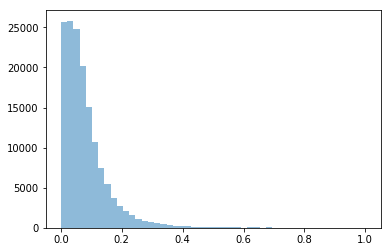

734.0


In [84]:
# VISUALISATION: visualise distribution
bins =  np.linspace(0, 1,50)
plt.hist(np.reshape(sim_matrix, (-1)), bins,alpha=.5)
plt.show()
# calculate high similaries
# divide by two because of double counting
print(np.sum(sim_matrix>0.4)/2)

In [200]:
# take duplicates - empirically (looking at example) decided to go for
# cosine similarity above 0.735 is a duplicate
# 0.735 
# determine the indices for large similarity
[a, b] = np.nonzero(sim_matrix>0.735)
# we'll only need to take off one of the two duplicates from the faq list
newa = a[a<b]
newb = b[a<b]

# DEBUG
new_sim_matrix = np.copy(sim_matrix)
new_sim_matrix[a,b] = 0

In [201]:
# Get a feel for the data we are deleting
print(newa,'\n\n',newb,'\n\n', len(newa), len(newb))

[  5   8   9  10  10  11  13  14  18  19  20  20  28  30  31  34  38  40
  41  41  41  41  46  49  52  59  59  59  62  62  67  71  71  72  75  75
  76  77  78  79  80  81  82  83  84  85  86  87  88  90  91  92  93  94
  97  99 100 101 105 106 106 107 108 110 110 112 112 113 113 113 114 114
 120 121 122 123 127 128 128 129 130 132 133 134 135 136 137 138 140 141
 144 144 144 145 145 145 146 146 146 148 148 149 153 154 155 156 164 165
 166 167 175 177 179 180 193 194 195 198 199 200 207 209 210 211 261 297
 299 340 342 354 373] 

 [188 190  33  34 276  35 281  36 205 206 198 282 218 251 174 276 361 289
 106 290 291 315 171 192 178 110 299 300 211 285 124  72  73  73  76 302
 303 304 235 236 234 233 250 249 243 244 256 257 228 252 240 255 245 246
 305 307 308 309 314 290 315 301 109 299 300 135 333 114 136 332 136 332
 232 239 254 247 317 200 318 183 327 329 330 331 333 332 334 335 337 338
 145 146 340 146 147 149 147 149 342 149 344 345 350 355 365 366 383 384
 385 388 269 271 273 275 2

In [199]:
# DEBUG: Check largest remaining index
ind = np.unravel_index(np.argmax(new_sim_matrix), (np.shape(new_sim_matrix)))
print('Index of largest similarity', ind)
print('Largest similarity value',np.max(new_sim_matrix),'\n')

# Look at FAQ to check
print(faq_ans[ind[0]],"\n\n", faq_ans[ind[1]])

Index of largest similarity (134, 331)
Largest similarity value 0.7396258787487598 

 To reply to a post in a newsfeed, click the Reply link below the post, and start typing in the text box. You can add the same features to a reply post as you can in a new conversation post, such as tags, links, videos, documents, mentions, and pictures.  Note the following details about replying to a post:      - You can reply only to posts that start a conversation; you cannot reply to other replies.      - You can reply to posts you see in the Following view or the Everyone view of your newsfeed. In the Following view, you only see conversations started by people you’re following. In the Everyone view, you see conversations that anyone in your organization may have started, including people you’re following.      - Some conversations are “locked” and do not allow additional replies.  

  If you want to reply to a post in a news feed, click the Reply link below the post and start typing the answer. Y

In [178]:
# The next boxes are for when I tried to do this manually. Eventually settled for an approximate way
# case A: this is a duplicate
newa = np.append(newa, [ind[0]]) 
newb = np.append(newb, [ind[1]])
print(newa,'\n\n',newb,'\n\n', len(newa), len(newb))
new_sim_matrix[ind] = 0
new_sim_matrix[ind[1], ind[0]] = 0

[ 10  11  14  30  38  59  67  71  75  90  94 107 108 110 112 113 113 114
 121 132 137 138 140 144 155 166 167 179 193 194 195 198 199 200 207 209
 210 211 261 297 373 177  62  62 285 135  81  79 112 141 149  85 106  87
  84  76 148 354   5 128  40 128 122  93 100] 

 [ 34  35  36 251 361 300 124  72 302 252 246 301 109 299 135 114 136 136
 239 329 334 335 337 340 365 385 388 273 276 278 277 282 283 318 279 281
 284 285 262 298 374 271 211 333 233 236 333 338 345 244 315 257 243 303
 344 376 188 318 289 200 254 245 308] 

 65 63


In [128]:
# The next boxes are for when I tried to do this manually. Eventually settled for an approximate way
# case B: this is a duplicate of a duplicate
newa = np.append(newa, ind)
print(newa,'\n\n',newb,'\n\n', len(newa), len(newb))
new_sim_matrix[ind] = 0
new_sim_matrix[ind[1], ind[0]] = 0

[ 10  11  14  30  38  59  67  71  75  90  94 107 108 110 112 113 113 114
 121 132 137 138 140 144 155 166 167 179 193 194 195 198 199 200 207 209
 210 211 261 297 373 177  62  62 285] 

 [ 34  35  36 251 361 300 124  72 302 252 246 301 109 299 135 114 136 136
 239 329 334 335 337 340 365 385 388 273 276 278 277 282 283 318 279 281
 284 285 262 298 374 271 211] 

 45 43


In [160]:
# The next boxes are for when I tried to do this manually. Eventually settled for an approximate way
# case C: this is not a duplicate
new_sim_matrix[ind] = 0
new_sim_matrix[ind[1], ind[0]] = 0

In [209]:
## DELETING DUPLICATES
faq_ans = np.delete(faq_ans, newb)
n_faq_ans = len(faq_ans)
faq_ques = np.delete(faq_ques, newb)
n_faq_ques = len(faq_ques)

Let's now build a basic similarity one:

In [213]:
# Use same TF-IDF model as above
# initialise model
vectoriser2 = TfidfVectorizer(strip_accents='unicode', lowercase=True,analyzer='word')
# create matrix: rows = all ans; cols = TI-IDF weighted word vector
all_ans = list(faq_ans) + ticket_ans
m2 = vectoriser2.fit_transform(all_ans)
# DEBUG:
print(m2.shape, len(faq_ans), len(ticket_ans), len(all_ans))

(5282, 15926) 278 5004 5282


In [225]:
# Calculate similarities between faq ans and ticket ans
SM = cosine_similarity(m2[:len(faq_ans),:], m2[len(faq_ans):,:])

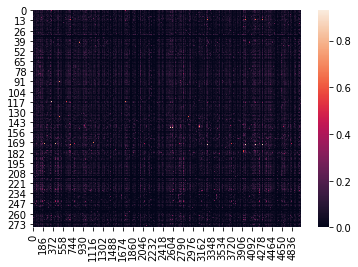

In [219]:
# VISUALISATION: heatmap of the similarity matrix
sns.heatmap(SM)
plt.show()

In [249]:
# Check stringest similarity
ind = np.unravel_index(np.argmax(SM), (np.shape(SM)))
print('Index of largest similarity', ind)
print('Largest similarity value',np.max(SM),'\n')

# Look at FAQ to check and ticket
print(faq_ans[ind[0]],"\n\n", ticket_ans[ind[1]])

print("Looks good (at least for the very best result ;) )")

Index of largest similarity (11, 3035)
Largest similarity value 0.9313016994211012 

Credit not loaded  The payment was stuck in the "reservation" stage, because you forgot to close the transaction with the "close" button.The payment is now completed and the money is available for printing.Please remember: always close the transaction window with the "close" button and wait until the ETH account summary is fully displayed after a payment. 

 Dear Mr Firat Cicek
 
The payment was stuck in the "reservation" stage, because you forgot to close
the transaction with the "close" button.The payment is now completed and the
money is available for printing. Please remember: always close the transaction
window with the "close" button and wait until the ETH account summary is fully
displayed after a payment.

sincerely,
Rudolf Friederich


Looks good (at least for the very best result ;) )


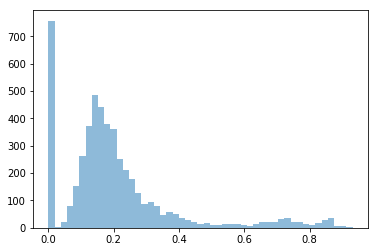

In [248]:
# VISUALISATION
# now let's look at how the similarity is scoring:
# here's a histogram of how good of a match we have for each ticket
strength_FAQ_ticket = np.max(SM, axis=0)
bins =  np.linspace(0, max(strength_FAQ_ticket),50)
plt.hist(strength_FAQ_ticket, bins,alpha=.5)
plt.show()
print("A lot of zero values that we should look into")

In [231]:
# VISUALISATION
# let's do a little of the opposite: which FAQ's get picked up often, which don't?
FAQ_per_ticket = np.argmax(SM, axis=0)
unique, counts = np.unique(FAQ_per_ticket, return_counts=True)

In [238]:
# here's a list of the ones that NEVER get picked up
# TODO: maybe let's check with the helpdesk guys?
print(np.delete(faq_ans, unique))

['Block a mailsender  You can add the sender on your personal blacklist. The following steps are required for this: Login on the pagehttp://www.password.ethz.chClick on meine Services/ E-Mail SpamfilterNow add the address in the field blacklist.'
 'VPN settings of the ETH  The settings for the ETH VPN are as follows:Server: sslvpn.ethz.chDecryption-typ: ipsec-pskUsername: Your ETH-UsernamePassword: Your passwordGroupname: ETHZ-spezialGrouppassword: This information you can find on this page:https://www1.ethz.ch/id/servicedesk/guide/vpn/vpn_secret'
 'setup of matlab installation aborts  First, you have to map your IDES-folder to a network drive. After that you should copy the whole folder 2014a from your IDES Matlab folder to your local harddisk. Finally you are able to begin the matlab installation from your local harddisk. Please follow strictly the instalallaton guide you receive from IDES by e-mail. A description how to connect your IDES network drive is attached to this e-mail.'
 '

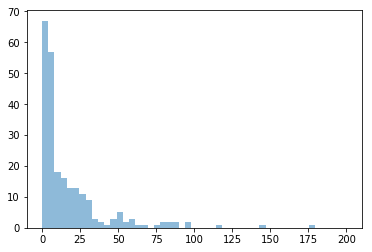

1 max(counts)= 761 
Corresponding FAQ:	 Phishing Mail warning  This is a phishing mail. You should delete it. If you clicked on the link and filled in your credentials, it is absolutely necessary to change the password immediately.Tips for changing the password are found here:https://www1.ethz.ch/id/servicedesk/guide/change_pw/index_EN


In [251]:
# VISUALISATION
# here is the distribution of matches over FAQs: how many FAQs have one similar ticket, 
#two and so on, till the largest: 761 counts to Phishing mail warning
bins =  np.linspace(0, 200,50)
plt.hist(counts, bins,alpha=.5)
plt.show()
print(np.sum(counts>200), '\nmax(counts)=',max(counts),'\nCorresponding FAQ:\t', faq_ans[unique[np.argmax(counts)]])

In [252]:
# next steps: 
# iterate over duplicate deletion: the method wont catch FAQs that are present 3+ times
# check if this is plausible
# look into which ones are 0 and why
# tell me what you think :)